## SPY Trading strategy with the data
In this notebook I will add some more columns to the data and create averages of sentiment and price scores.
The data is then used to create several trading strategies with them and test their profitability.
The profitability will be compared with a simpel buy and hold the index strategy for the same time period to conclude wether or not the market can be beat by exploiting reddit sentiment data

In [1]:
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
import numpy as np
import pandas as pd
import csv
import time
import datetime
import warnings 
warnings.filterwarnings("ignore")
import pinkfish as pf
import talib
from talib import MA_Type
from talib.abstract import *

ModuleNotFoundError: No module named 'pinkfish'

In [ ]:
# set start and end dates as well as capital base for backtesting algorithm
start = datetime.datetime(*pf.SP500_BEGIN)
end = datetime.datetime.now()
capital = 10000

In [ ]:
# load local data
df = pd.read_csv('timeseries_final.csv')
ts1 = df
ts1.head(2)

## Some additional data is needed to write an algorithm for the trading strategy

In [2]:
# create sentiment change % column
ts1['sent_change %']= ((ts1['sent_smooth'][:-1].values / ts1['sent_smooth'][1:] - 1)*100) # 

# create moving average with 5 days for smoothed sentiment score
sma5 = SMA(ts1['sent_smooth'], timeperiod=5)
ts1['sent_average_5'] = sma5

# create a slower moving average with 10 days for smoothed sentiment score
sma5 = SMA(ts1['sent_smooth'], timeperiod=10)
ts1['sent_average_10'] = sma5

# moving average of the last 50 prices
sma50 = SMA(ts1['spy'], timeperiod=50)
ts1['sma_50_price'] = sma50

# moving average of the  last 100 prices
sma100 = SMA(ts1['spy'], timeperiod=100)
ts1['sma_100_price'] = sma100

ts1.head(2)

NameError: name 'ts1' is not defined

In [5]:
# set date as index
ts1 = ts1.set_index('date')
ts1.head(2)

,spy,sent,fourier 25,sent_smooth,year,month,week,weekday,return %,sent_change %,sent_average_5,sent_average_10,sma_50_price,sma_100_price
date,,,,,,,,,,,,,,
2018-08-10,269.115723,-9.8812,(-12.354836451981537+0.7836860343392514j),-12.354836,2018,Aug,32,Friday,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-15,267.804230,-17.0701,(-9.707921625477068+0.4041492325989481j),-9.707922,2018,Aug,33,Wednesday,0.489721,27.265515,NaN,NaN,NaN,NaN


In [6]:
# get pinkfish timeseries with additional data to create backtesting algorithm
ts2 = pf.fetch_timeseries('SPY')
ts2.head(2)

,high,low,open,close,volume,adj_close
date,,,,,,
1993-01-29,43.96875,43.75000,43.96875,43.9375,1003200.0,25.884184
1993-02-01,44.25000,43.96875,43.96875,44.2500,480500.0,26.068277


In [7]:
# merge dataframe together 
ts = pd.merge(ts1, ts2, left_index=True, right_index=True)
ts.head(2)

,spy,sent,fourier 25,sent_smooth,year,month,week,weekday,return %,sent_change %,sent_average_5,sent_average_10,sma_50_price,sma_100_price,high,low,open,close,volume,adj_close
date,,,,,,,,,,,,,,,,,,,,
2018-08-10,269.115723,-9.8812,(-12.354836451981537+0.7836860343392514j),-12.354836,2018,Aug,32,Friday,NaN,NaN,NaN,NaN,NaN,NaN,284.059998,282.359985,283.450012,283.160004,77076000.0,269.115723
2018-08-15,267.804230,-17.0701,(-9.707921625477068+0.4041492325989481j),-9.707922,2018,Aug,33,Wednesday,0.489721,27.265515,NaN,NaN,NaN,NaN,282.540009,280.160004,282.380005,281.779999,102925400.0,267.804230


In [8]:
# check columns ander numerical values
ts.describe()

,spy,sent,sent_smooth,year,week,return %,sent_change %,sent_average_5,sent_average_10,sma_50_price,sma_100_price,high,low,open,close,volume,adj_close
count,486.000000,486.000000,486.000000,486.000000,486.000000,485.000000,485.000000,482.000000,477.000000,437.000000,387.000000,486.000000,486.000000,486.000000,486.000000,4.860000e+02,486.000000
mean,314.837299,-3.158943,-3.158943,2019.625514,26.020576,-0.074958,16.932241,-3.078961,-3.020016,311.841311,310.408652,322.992592,318.823622,321.049012,321.023292,8.563834e+07,314.837299
std,48.482467,14.476494,8.329532,0.937032,16.031142,1.738947,328.426749,8.110411,7.596748,42.506174,36.679622,44.859718,44.904618,44.882492,44.923755,4.670516e+07,48.482467
min,219.431061,-43.698100,-20.699065,2018.000000,1.000000,-14.790749,-2021.012864,-20.419858,-19.620498,252.378844,261.376371,229.679993,218.259995,228.190002,222.949997,2.027000e+07,219.431061
25%,275.836182,-12.657500,-8.776281,2019.000000,11.000000,-0.844368,-14.025400,-8.443056,-8.018571,280.981096,283.507951,288.055000,285.287498,285.987503,286.542511,5.711452e+07,275.836182
50%,304.966934,-3.286300,-3.518968,2020.000000,26.000000,-0.157109,-2.375574,-3.465498,-3.512575,300.534335,298.914866,313.529999,310.100006,312.104996,311.860001,7.358300e+07,304.966934
75%,352.475662,5.691575,1.500217,2020.000000,40.000000,0.428952,12.717429,1.758546,1.713717,340.944888,340.566147,357.680000,353.902496,355.595001,355.137489,9.797235e+07,352.475662
max,422.119995,46.818000,22.493322,2021.000000,53.000000,12.286831,6259.836394,21.590413,18.998749,403.270109,389.367112,422.820007,419.160004,422.500000,422.119995,3.922207e+08,422.119995


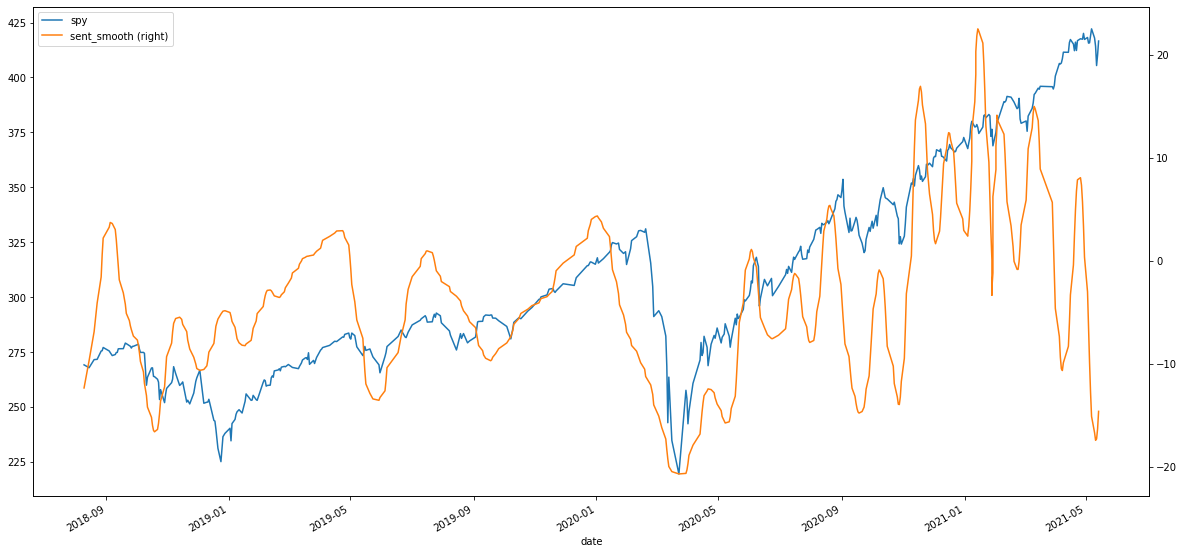

In [9]:
# plot price against sentiment
ts[['spy', 'sent_smooth']].plot(secondary_y='sent_smooth', figsize=(20, 10));

In [10]:
# finalize timerseries before creating algorithms
ts, start = pf.finalize_timeseries(ts, start)

In [14]:
# creating a tradinglog to save results, initiate object to store them
pf.TradeLog.cash = capital
tlog = pf.TradeLog('SPY')
dbal = pf.DailyBal() # set daily balance object
symbol = 'SPY'

## First strategy: Exploit changing trends in sentiment.
This strategy will take a look at the sentiment averages. I created one fast and a slower average. 
The algorithm will buy when the short term sentiment increases over the long term sentiment, and it will sell when the long term sentiment catches up.

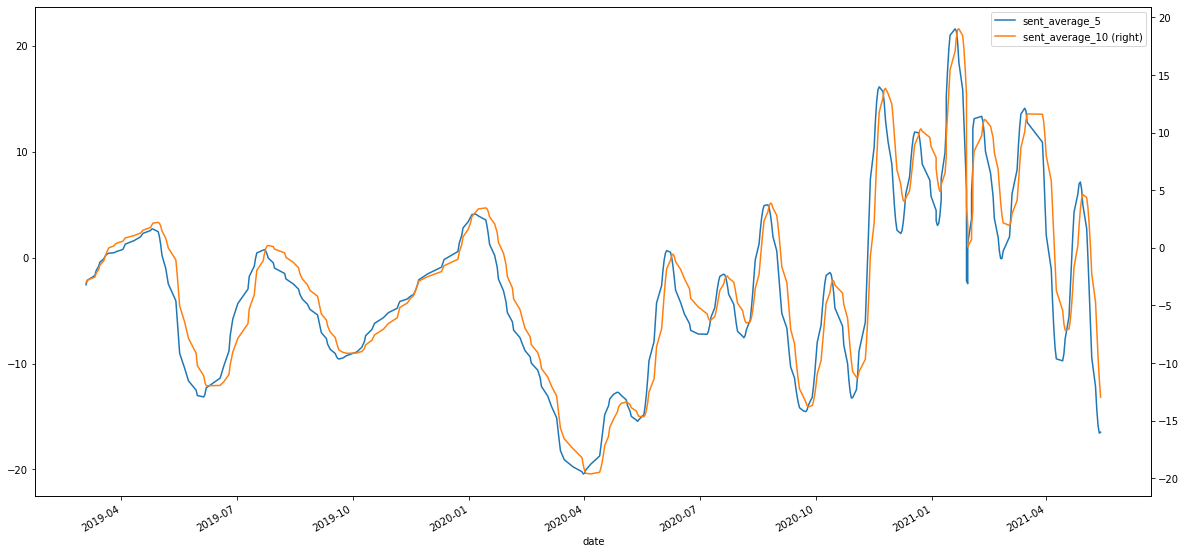

In [13]:
# plot price against sentiment
ts[['sent_average_5', 'sent_average_10']].plot(secondary_y='sent_average_10', figsize=(20, 10));

In [52]:
import time
t0 = time.time()

for i, row in enumerate(ts.itertuples()): # iterate over dataframe

    date = row.Index.to_pydatetime() # date is date from index
    high = row.high; low = row.low; close = row.close; # set high low and close according to current row
    end_flag = pf.is_last_row(ts, i) # end at last row
    shares = 0 # initial shares amount
    
    # Buy conditions:
    if tlog.shares == 0: # if currently no shares in portfolio
        if row.sent_average_5 > row.sent_average_10 and ts['sent_average_5'][i-1] <= ts['sent_average_10'][i-1]: 
            # Enter buy in trade log
            shares = tlog.buy(date, close)  
    # Sell
    else:
        if ((row.sent_average_5 < row.sent_average_10 and ts['sent_average_5'][i-1] >= ts['sent_average_10'][i-1])
            or end_flag):
            # Enter sell in trade log
            shares = tlog.sell(date, close)

    if shares > 0: # print buy orders
        print("{0} BUY  {1} {2} @ {3:.2f}".format(
              date, shares, symbol, close))
    elif shares < 0: # print sell orders
        print("{0} SELL {1} {2} @ {3:.2f}".format(
              date, -shares, symbol, close))

    # Record daily balance
    dbal.append(date, high, low, close)  

t1 = time.time()
total = t1-t0
print(total)

2019-03-04 00:00:00 BUY  35 SPY @ 279.40
2019-05-01 00:00:00 SELL 35 SPY @ 291.81
2019-06-18 00:00:00 BUY  35 SPY @ 292.40
2019-07-26 00:00:00 SELL 35 SPY @ 302.01
2019-10-04 00:00:00 BUY  36 SPY @ 294.35
2020-01-15 00:00:00 SELL 36 SPY @ 328.19
2020-04-06 00:00:00 BUY  45 SPY @ 264.86
2020-05-04 00:00:00 SELL 45 SPY @ 283.57
2020-05-19 00:00:00 BUY  43 SPY @ 291.97
2020-06-10 00:00:00 SELL 43 SPY @ 319.00
2020-07-10 00:00:00 BUY  44 SPY @ 317.59
2020-07-23 00:00:00 SELL 44 SPY @ 322.96
2020-08-10 00:00:00 BUY  42 SPY @ 335.57
2020-08-27 00:00:00 SELL 42 SPY @ 348.33
2020-09-28 00:00:00 BUY  44 SPY @ 334.19
2020-10-15 00:00:00 SELL 44 SPY @ 347.50
2020-11-03 00:00:00 BUY  45 SPY @ 336.03
2020-11-25 00:00:00 SELL 45 SPY @ 362.66
2020-12-10 00:00:00 BUY  45 SPY @ 366.73
2020-12-23 00:00:00 SELL 45 SPY @ 367.57
2021-01-08 00:00:00 BUY  43 SPY @ 381.26
2021-01-22 00:00:00 SELL 43 SPY @ 382.88
2021-01-29 00:00:00 BUY  45 SPY @ 370.07
2021-02-12 00:00:00 SELL 45 SPY @ 392.64
2021-03-03 00:00

In [53]:
# Retrieve raw log and trade log DataFrames
rlog = tlog.get_log_raw()
tlog = tlog.get_log()

In [54]:
tlog.tail()

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
9,2020-12-10,366.730011,2020-12-23,367.570007,0.839996,37.799835,45,6587.170349,LONG,SPY
10,2021-01-08,381.260010,2021-01-22,382.880005,1.619995,69.659790,43,6656.830139,LONG,SPY
11,2021-01-29,370.070007,2021-02-12,392.640015,22.570007,1015.650330,45,7672.480469,LONG,SPY
12,2021-03-03,381.420013,2021-03-29,395.779999,14.359985,660.559326,46,8333.039795,LONG,SPY
13,2021-04-19,415.209991,2021-05-03,418.200012,2.990021,131.560913,44,8464.600708,LONG,SPY


In [55]:
# Retrieve daily balance dataframe
dbal = dbal.get_log(tlog)
dbal.tail()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2021-05-10,18464.600708,18464.600708,18464.600708,0,18464.600708,1.0,-
2021-05-11,18464.600708,18464.600708,18464.600708,0,18464.600708,1.0,-
2021-05-12,18464.600708,18464.600708,18464.600708,0,18464.600708,1.0,-
2021-05-13,18464.600708,18464.600708,18464.600708,0,18464.600708,1.0,-
2021-05-14,18464.600708,18464.600708,18464.600708,0,18464.600708,1.0,-


In [56]:
# getting closing balances
close = dbal['close']

running_max = pd.Series(close).expanding(min_periods=1).max()
cur_dd = (close - running_max) / running_max * 100
cur_dd.tail(10)

date
2021-05-03   -0.441267
2021-05-04   -0.441267
2021-05-05   -0.441267
2021-05-06   -0.441267
2021-05-07   -0.441267
2021-05-10   -0.441267
2021-05-11   -0.441267
2021-05-12   -0.441267
2021-05-13   -0.441267
2021-05-14   -0.441267
Name: close, dtype: float64

In [57]:
# get maximum drawdown in this strategy, meaning unrealised loss during a trade
dd_max = min(0, cur_dd.min())
idx = cur_dd.idxmin()

print('max drawdown: ' + str(dd_max) + '\n' + 'timestamp of max dd: ' + str(idx))

max drawdown: -4.718932059802745
timestamp of max dd: 2020-04-21 00:00:00


In [59]:
def max_closed_out_drawdown(close):
    """
    Only compare each point to the previous running peak O(N).
    """
    running_max = pd.Series(close).expanding(min_periods=1).max()
    cur_dd = (close - running_max) / running_max * 100
    dd_max = min(0, cur_dd.min())
    idx = cur_dd.idxmin()

    dd = pd.Series(dtype='object')
    dd['max'] = dd_max
    dd['peak'] = running_max[idx]
    dd['trough'] = close[idx]
    dd['peak_date'] = close[close == dd['peak']].index[0].strftime('%Y-%m-%d')
    dd['trough_date'] = idx.strftime('%Y-%m-%d')
    close = close[close.index > idx]

    rd_mask = close > dd['peak']
    if rd_mask.any():
        dd['recovery_date'] = close[rd_mask].index[0].strftime('%Y-%m-%d')
    else:
        dd['recovery_date'] = 'Not Recovered Yet'

    return dd

In [60]:
dd = max_closed_out_drawdown(dbal['close'])
dd

max                -4.71893
peak                  12969
trough                12357
peak_date        2020-04-17
trough_date      2020-04-21
recovery_date    2020-04-27
dtype: object

In [61]:
# printing statistics 
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                  2019-03-04
end                                                    2021-05-14
beginning_balance                                           10000
ending_balance                                            18464.6
total_net_profit                                           8464.6
gross_profit                                               8464.6
gross_loss                                                      0
profit_factor                                                1000
return_on_initial_capital                                  84.646
annual_return_rate                                        32.2194
trading_period                           2 years 2 months 10 days
pct_time_in_market                                        50.3876
margin                                                          1
avg_leverage                                                    1
max_leverage                                                    1
min_levera

In [62]:
benchmark = pf.Benchmark(symbol, capital, start, end)
benchmark.run()

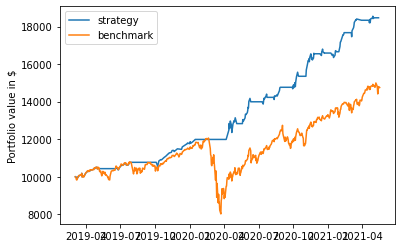

In [26]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

***